In [134]:
import cv2
import numpy as np

def createDetector():
    detector = cv2.ORB_create(nfeatures=250, firstLevel=7)
    return detector

def getFeatures(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = createDetector()
    kps, descs = detector.detectAndCompute(gray, None)
    return kps, descs, img.shape[:2][::-1]

def detectFeatures(img, train_features):
    train_kps, train_descs, shape = train_features
    # get features from input image
    kps, descs, _ = getFeatures(img)
    # check if keypoints are extracted
    if not kps:
        return None
    # now we need to find matching keypoints in two sets of descriptors (from sample image, and from current image)
    # knnMatch uses k-nearest neighbors algorithm for that
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(train_descs, descs, k=2)
    good = []
    # apply ratio test to matches of each keypoint
    # idea is if train KP have a matching KP on image, it will be much closer than next closest non-matching KP,
    # otherwise, all KPs will be almost equally far
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
    # stop if we didn't find enough matching keypoints
    if len(good) < 0.1 * len(train_kps):
        return None
    # estimate a transformation matrix which maps keypoints from train image coordinates to sample image
    src_pts = np.float32([train_kps[m[0].queryIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps[m[0].trainIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    m, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if m is not None:
        # apply perspective transform to train image corners to get a bounding box coordinates on a sample image
        scene_points = cv2.perspectiveTransform(np.float32([(0, 0), (0, shape[0] - 1), (shape[1] - 1, shape[0] - 1), (shape[1] - 1, 0)]).reshape(-1, 1, 2), m)
        rect = cv2.minAreaRect(scene_points)
        # check resulting rect ratio knowing we have almost square train image
        if rect[1][1] > 0 and 0.8 < (rect[1][0] / rect[1][1]) < 1.2:
            return rect
    return None

Number of Keypoints Detected In The Training Image:  250


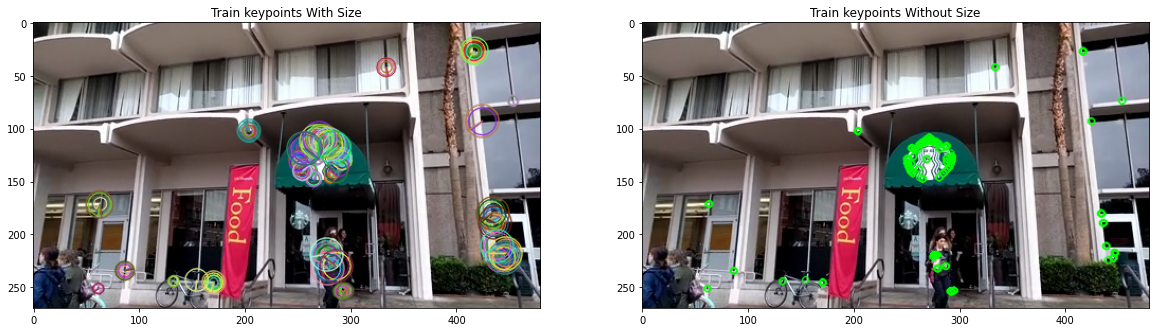

In [135]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

image = cv2.imread("starbucks_shot.bmp")
#image = cv2.imread("dataset/Brand Images/starbucks_logo.bmp")
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
train_keypoints = getFeatures(training_image)[0]

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

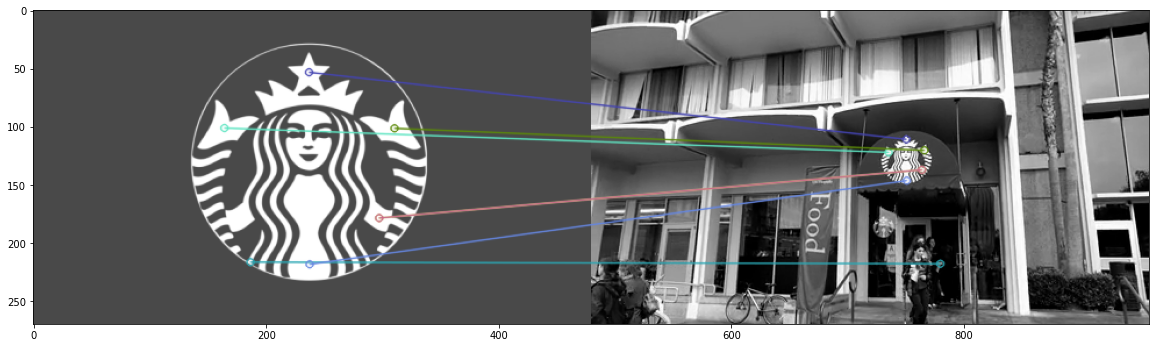

(<matplotlib.image.AxesImage at 0x11b7d35e0>, None)

In [40]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread("dataset/Brand Images/starbucks_logo.bmp", cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread("starbucks_shot.bmp", cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create(nfeatures=100)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(img3),plt.show()

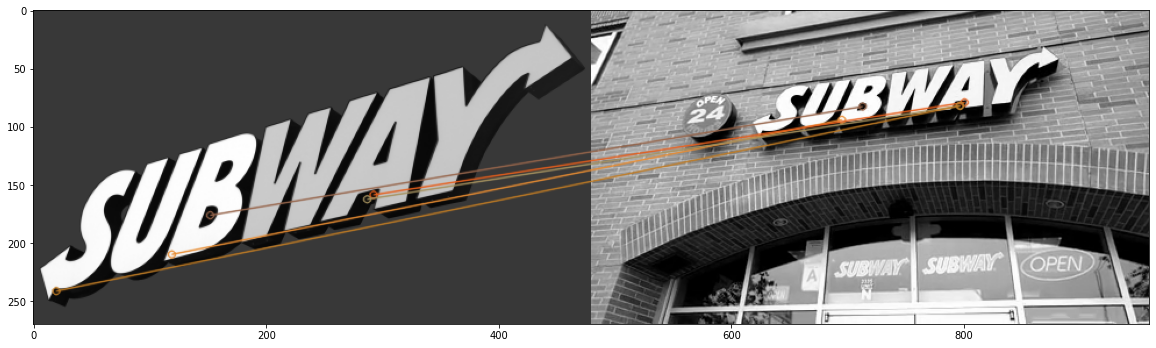

(<matplotlib.image.AxesImage at 0x1185e15b0>, None)

In [35]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread("dataset/Brand Images/subway_logo.bmp", cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread("subway_shot.bmp", cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create(nfeatures=50)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,10))
plt.imshow(img3),plt.show()

number of good matches: 8


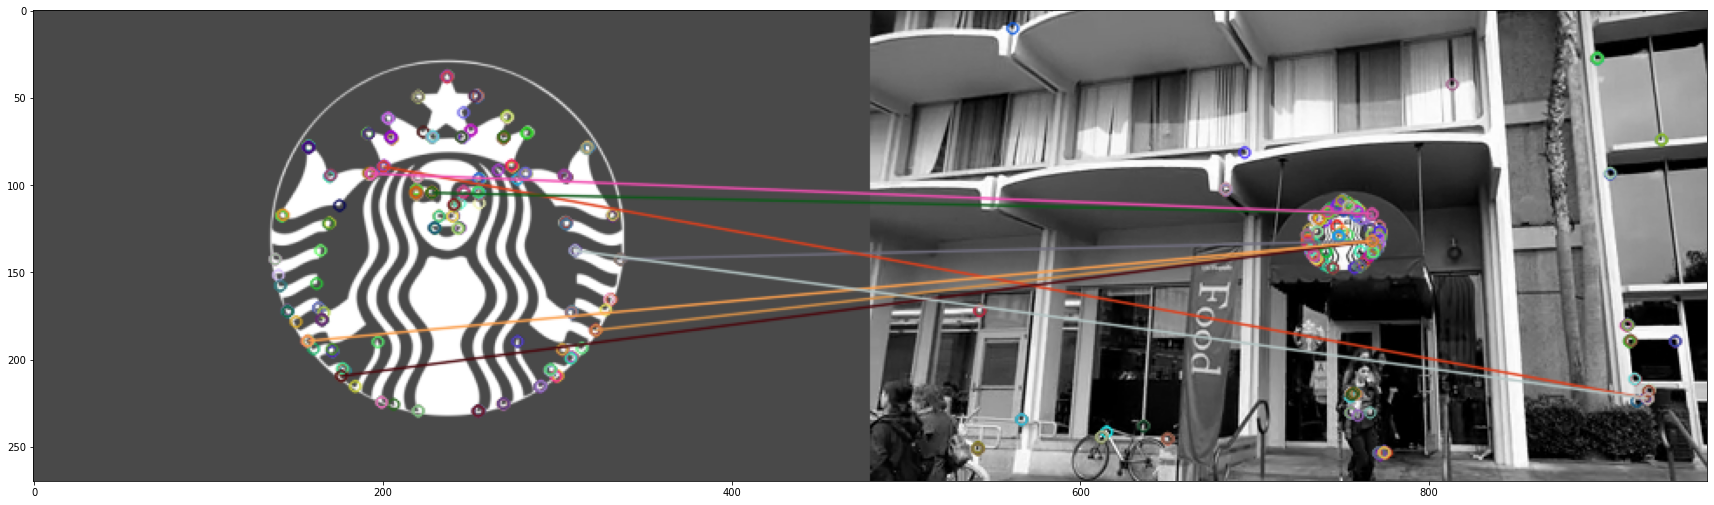

In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

query_image = cv2.imread("dataset/Brand Images/starbucks_logo.bmp", cv2.IMREAD_GRAYSCALE)
train_image = cv2.imread("starbucks_shot.bmp", cv2.IMREAD_GRAYSCALE)

feature_detector = cv2.ORB_create(nfeatures=300, scaleFactor=1.25, firstLevel=7, fastThreshold = 15)
query_keypoints, query_descriptors = feature_detector.detectAndCompute(query_image, None)
train_keypoints, train_descriptors = feature_detector.detectAndCompute(train_image, None)

feature_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = feature_matcher.knnMatch(query_descriptors, train_descriptors, k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append([m])


result = cv2.drawMatchesKnn(query_image, query_keypoints, train_image, train_keypoints, good, None) #, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print("number of good matches:", len(good))
plt.figure(figsize=(30,15))
plt.imshow(result)
plt.show()


In [ ]:
'''
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(train_descs, descs, k=2)
    good = []
    # apply ratio test to matches of each keypoint
    # idea is if train KP have a matching KP on image, it will be much closer than next closest non-matching KP,
    # otherwise, all KPs will be almost equally far
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
    # stop if we didn't find enough matching keypoints
    if len(good) < 0.1 * len(train_kps):
        return None
    # estimate a transformation matrix which maps keypoints from train image coordinates to sample image
    src_pts = np.float32([train_kps[m[0].queryIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    dst_pts = np.float32([kps[m[0].trainIdx].pt for m in good
                          ]).reshape(-1, 1, 2)
    m, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if m is not None:
        # apply perspective transform to train image corners to get a bounding box coordinates on a sample image
        scene_points = cv2.perspectiveTransform(np.float32([(0, 0), (0, shape[0] - 1), (shape[1] - 1, shape[0] - 1), (shape[1] - 1, 0)]).reshape(-1, 1, 2), m)
        rect = cv2.minAreaRect(scene_points)
        # check resulting rect ratio knowing we have almost square train image
        if rect[1][1] > 0 and 0.8 < (rect[1][0] / rect[1][1]) < 1.2:
            return rect
    return None
'''

In [2]:
import cv2

help(cv2.ORB_create)

Help on built-in function ORB_create:

ORB_create(...)
    ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]]) -> retval
    .   @brief The ORB constructor
    .   
    .       @param nfeatures The maximum number of features to retain.
    .       @param scaleFactor Pyramid decimation ratio, greater than 1. scaleFactor==2 means the classical
    .       pyramid, where each next level has 4x less pixels than the previous, but such a big scale factor
    .       will degrade feature matching scores dramatically. On the other hand, too close to 1 scale factor
    .       will mean that to cover certain scale range you will need more pyramid levels and so the speed
    .       will suffer.
    .       @param nlevels The number of pyramid levels. The smallest level will have linear size equal to
    .       input_image_linear_size/pow(scaleFactor, nlevels - firstLevel).
    .       @param edgeThreshold This i